In [ ]:
#pip install python-resize-image #Installs resizeimage

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image
from resizeimage import resizeimage

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

In [2]:
#####################################Import Labels##########################
labels = pd.read_csv("Label.csv");
y = pd.Series(labels.Label.values);
pd.Series(y).value_counts()

1    10
0    10
dtype: int64

In [3]:
#Pulls Image from File
def get_image(row_id, root="Green_Vessel/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    filename = "{}.png".format(row_id+1)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    img = resizeimage.resize_contain(img, [210, 210])    #Resize Image to 210x210
    return np.array(img)

In [4]:
#Create Features by combining previous blocks

def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2grey(img)
    # get HOG features from greyscale image
    #hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack(color_features)
    return flat_features


In [5]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        # load image
        img = get_image(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)

#Get Shape of Feature Matrix
print('Feature matrix shape is: ', feature_matrix.shape)

Feature matrix shape is:  (20, 176400)


In [6]:
# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
images_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
images_pca = ss.fit_transform(images_stand)
# look at new shape
print('PCA matrix shape is: ', images_pca.shape)

PCA matrix shape is:  (20, 176400)


In [7]:
#Split Data
X = pd.DataFrame(images_pca)

X_train=X[0:11]
X_test=X[11:21]
y_train=y[0:11]
y_test=y[11:21]

In [8]:
from sklearn.model_selection import cross_val_score

clf = SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([1. , 0.5, 0.5, 0.5, 0.5])

In [9]:
#Train Model
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)

# fit model
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [10]:
#Change path to be the location of the SVM pickle
os.chdir("C:\\Users\\Maximillian\\Desktop\\Code Demo\\Example\\Pickles")

from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(svm, 'GreenVessel.pkl')
  


C:\Users\Maximillian\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['GreenVessel.pkl']

In [11]:
del svm

In [12]:


from sklearn.externals import joblib

# Load the model from the file 
svm = joblib.load('GreenNormal.pkl')  

In [13]:
#Evaluate Model
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print('Model accuracy is: ', accuracy)


Model accuracy is:  0.4444444444444444


In [14]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix


confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

TN=confmat[0,0];
FN=confmat[1,0];
FP=confmat[0,1];
TP=confmat[1,1];

sensitivity=TP/(TP+FN)
specificity=TN/(TN+FP)

print(sensitivity)
print(specificity)

[[0 5]
 [0 4]]
1.0
0.0


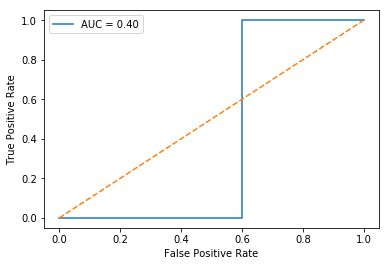

In [15]:
#Generate ROC

# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

#plt.title('RBF Normal Map ROC')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');
#plt.savefig('NormalGreenMapAUC.png')

In [16]:
Q=svm.coef_
Q.shape
Pixel_Weights=Q.reshape(210,210,4)

Text(0.5, 1.0, 'Linear Normal Maps Red Channel Weights')

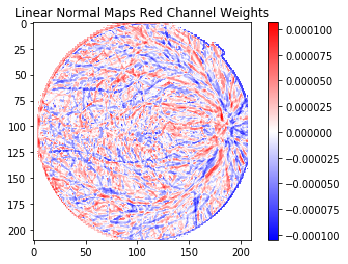

In [17]:
plt.imshow(Pixel_Weights[:,:,0],cmap='bwr')
plt.colorbar()
plt.title('Linear Normal Maps Red Channel Weights')
#plt.savefig('Linear Green Maps Red Channel Weights bwr.png')

Text(0.5, 1.0, 'Linear Normal Maps Green Channel Weights')

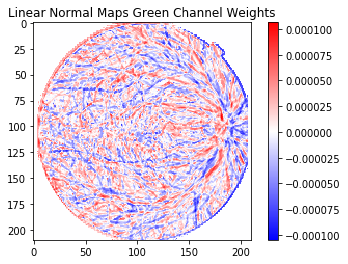

In [18]:
plt.imshow(Pixel_Weights[:,:,1],cmap='bwr')
plt.colorbar()
plt.title('Linear Normal Maps Green Channel Weights')
#plt.savefig('Linear Green Maps Green Channel Weights bwr.png')

Text(0.5, 1.0, 'Linear Normal Maps Blue Channel Weights')

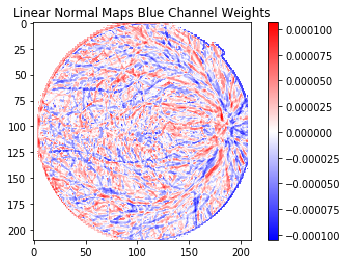

In [19]:
plt.imshow(Pixel_Weights[:,:,2],cmap='bwr')
plt.colorbar()
plt.title('Linear Normal Maps Blue Channel Weights')
#plt.savefig('Linear Green Maps Blue Channel Weights bwr.png')